In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import mean_absolute_error,accuracy_score,classification_report,precision_recall_fscore_support, confusion_matrix,r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.pipeline import Pipeline



## Data reading, feature selection

In [46]:
data = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')

data = data.dropna()

print(data.isna().sum())
print(data['Genre'].unique())
print(data.dtypes)
##Nagggyon sok 0 kozeli, igy is lesz eleg ertek 
print(data['Global_Sales'])
print(data['Global_Sales'].isnull().count())
#Kiszedjuk az ismeretlen jatekokat
data = data[data['Global_Sales'] >= 0.2]

data['Name'].count()

4172

## LabelEncoding, Splittin

In [99]:
#y - genre feladat
y = data['Genre']
#nem kellenek - Name egyedi minden jatekhoz
X = data.drop(['Genre','Name'],axis=1)

label_encoder = LabelEncoder()

#String tipusokat encdoding
y = label_encoder.fit_transform(y)

X['Rating'] = label_encoder.fit_transform(X['Rating'])
X['Platform'] = label_encoder.fit_transform(X['Platform'])
X['Publisher'] = label_encoder.fit_transform(X['Publisher'])
X['Developer'] = label_encoder.fit_transform(X['Developer'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)
st_x= StandardScaler()  
X_train= st_x.fit_transform(X_train)  
X_test= st_x.transform(X_test)  
#print(X_train)

## RandomForest
### Feature 
### HyperParameter

In [100]:

#nem lenyeges feature eltavolitas
#X_rf = X.drop(['JP_Sales'],axis=1)
X_rf = X
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size=0.2, random_state=420)
rf_classifier = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split=2, n_estimators= 300)
rf_classifier.fit(X_train,y=y_train)
y_pred = rf_classifier.predict(X_test)

print(accuracy_score(y_test,y_pred))
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')

0.5238095238095238
MAE: 2.375824175824176


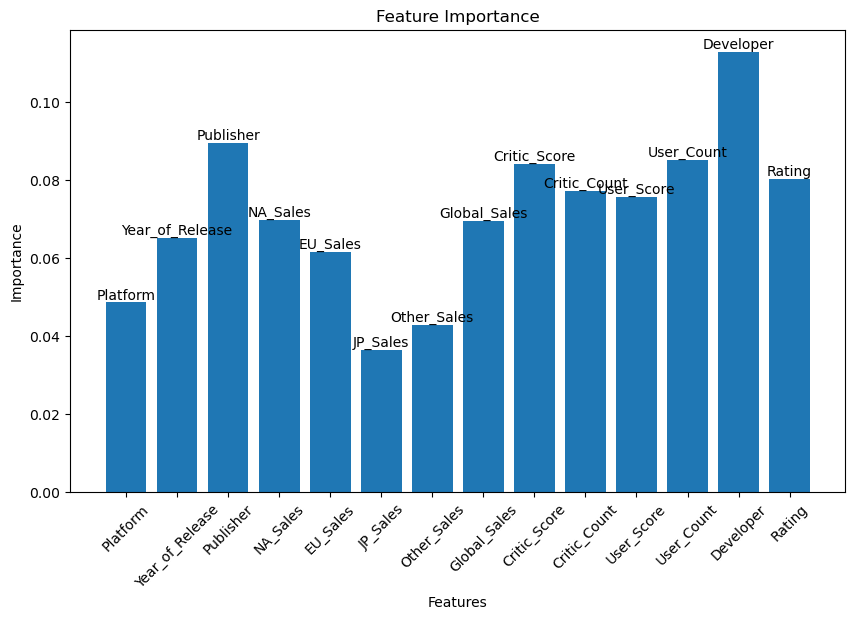

In [53]:

importance_values = rf_classifier.feature_importances_
feature_names = X_rf.columns

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(feature_names)), importance_values)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(range(len(feature_names)), feature_names, rotation=45)  


for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, feature_names[i], ha='center', va='bottom')

plt.show()


In [41]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
best_rf_classifier = RandomForestClassifier(**best_params)
best_rf_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_rf_classifier.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print('Accuracy: ',accuracy_score(y_test, y_pred))


## SVM

In [101]:
svm = SVC(C= 10, gamma= 0.1, kernel= 'rbf')
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')

0.26373626373626374
MAE: 4.864468864468864


In [64]:

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}


svm_classifier = SVC()


grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')


grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [65]:

svm = SVC(**best_params)
svm.fit(X_train, y_train)


y_pred = svm.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print('Accuracy: ',accuracy_score(y_test,y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.64      0.54       349
           1       0.08      0.02      0.03        51
           2       0.37      0.37      0.37        67
           3       0.31      0.18      0.23        84
           4       0.27      0.26      0.26        78
           5       0.43      0.23      0.30        26
           6       0.46      0.26      0.33       125
           7       0.41      0.33      0.37       137
           8       0.35      0.42      0.38       155
           9       0.36      0.15      0.21        62
          10       0.56      0.75      0.64       183
          11       0.19      0.10      0.13        48

    accuracy                           0.43      1365
   macro avg       0.35      0.31      0.32      1365
weighted avg       0.40      0.43      0.40      1365

Accuracy:  0.42857142857142855


## LogisticRegression 

In [75]:
X_lr = X
X_train, X_test, y_train, y_test = train_test_split(X_lr, y, test_size=0.2, random_state=420)
lr = LogisticRegression(C= 10, penalty= 'l1',solver= 'liblinear')
lr.fit(X_train,y_train)

st_x= StandardScaler()  
X_train= st_x.fit_transform(X_train)  
X_test= st_x.transform(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')

Accuracy: 0.47692307692307695
MAE: 2.7304029304029305


c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [67]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

logistic_classifier = LogisticRegression()

grid_search = GridSearchCV(logistic_classifier, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\miniconda3\envs\myenv\Lib\site-pack

Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [68]:
best_logistic_classifier = LogisticRegression(**best_params)
best_logistic_classifier.fit(X_train, y_train)

y_pred = best_logistic_classifier.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.72      0.47       349
           1       0.00      0.00      0.00        51
           2       0.22      0.03      0.05        67
           3       0.00      0.00      0.00        84
           4       0.16      0.10      0.13        78
           5       0.43      0.12      0.18        26
           6       0.14      0.02      0.03       125
           7       0.34      0.18      0.24       137
           8       0.22      0.17      0.19       155
           9       0.00      0.00      0.00        62
          10       0.39      0.74      0.51       183
          11       0.29      0.10      0.15        48

    accuracy                           0.34      1365
   macro avg       0.21      0.18      0.16      1365
weighted avg       0.25      0.34      0.26      1365

0.3362637362637363


c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Voting

In [79]:
# Initialize the classifiers
rf = RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split=2, n_estimators= 300)
lr = LogisticRegression(C= 10, penalty= 'l1',solver= 'liblinear')
svm = SVC(C= 10, gamma= 0.1, kernel= 'rbf')

# Create the Voting Classifier
voting_svm = VotingClassifier(
    estimators=[('rf', rf),  ('svm', svm), ('lr',lr)],
    voting='hard'
)

# Train the ensemble classifier
voting_svm.fit(X_train, y_train)

# Make predictions
y_pred = voting_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')

c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.3597069597069597
MAE: 3.8857142857142857


## ADABOOSTING

In [87]:
rf =  RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split=2, n_estimators= 300)

# Initialize the AdaBoost classifier
ada_classifier = AdaBoostClassifier(base_estimator=rf,  n_estimators=3, random_state=42)

# Train the classifier
ada_classifier.fit(X_train, y_train)
# Make predictions
y_pred = ada_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(f'MAE: {mean_absolute_error(y_test,y_pred)}')

c:\ProgramData\miniconda3\envs\myenv\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.5194139194139195
MAE: 2.4703296703296704
